In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
# from torchviz import make_dot
import os, fnmatch
import torchaudio
import sounddevice as sd
import soundfile as sf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import array
import torch.fft as fft
from CustomDataloader import CustomDataloaderCreator,DataConfig
from Training import Trainer
from tqdm import tqdm

from plottingHelper import compareTwoAudios

In [ ]:
# Set up torch and cuda
dtype = torch.float32
# dtype = torch.float64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_tensor_type('torch.cuda.FloatTensor' if torch.cuda.is_available() else 'torch.FloatTensor')

print(device)
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

### # Defining parameters

In [ ]:
noisyPath = '/home/ubuntu/OticonStuff/dataset/train'
cleanPath = '/home/ubuntu/OticonStuff/dataset/y_train'
noisy_files_list = fnmatch.filter(os.listdir(noisyPath), '*.wav')
clean_files_list = fnmatch.filter(os.listdir(cleanPath), '*.wav')

# print("Number of noisy files: ", len(noisy_files_list))
# print("Number of clean files: ", len(clean_files_list))
# print("Noisy file: ", noisy_files_list[1])
# print("Clean file: ", clean_files_list[1])

#Corresponds to 512 -> 32ms
frameSize = 512 * 8
#Corresponds to 32 -> 2ms
stride_length = 256 * 8
speechSampleSize = 48000  
sampleRate = 16000

# Model Input Buffer ( How many frames of size "frameSize" to be fed to the model)
modelBufferFrames = 2

# Forward pass buffer
fft_freq_bins = frameSize // 2 + 1
numOfFFTFrames = (speechSampleSize - frameSize) // (stride_length) + 1

print("Frame Size: ", frameSize)
print("Stride Length: ", stride_length)
print("Speech Sample Size: ", speechSampleSize)
print("Sample Rate: ", sampleRate)
print("Model Buffer Frames: ", modelBufferFrames)
print("Buffer Size: ", frameSize)
print("FFT Frequency Bins: ", fft_freq_bins)
print("Number of FFT Frames: ", numOfFFTFrames)


In [ ]:
#Split into train and temp ( 70-15-15 split for now)
X_train, X_temp, y_train, y_temp = train_test_split(noisy_files_list, clean_files_list, test_size=0.3, random_state=42)

#Splitting the temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# print(f'shape of numpy X_train: {np.array(X_train).shape}')
# # print(f'shape of numpy y_train: {np.array(y_train).shape}')
# print(f'shape of numpy X_test: {np.array(X_test).shape}')
# # print(f'shape of numpy y_test: {np.array(y_test).shape}')

# print(f'shape of numpy X_val: {np.array(X_val).shape}')
# # print(f'shape of numpy y_test: {np.array(y_test).shape}')


#All defaults in dataconfig
dataConfig = DataConfig(
    batchSize= 256,
    dtype= dtype,
    device = device,
    learningRate = 0.01,
    frameSize = frameSize, 
    stride_length = stride_length,
    sample_rate = sampleRate,
    duration = 3,
    n_fft = frameSize,
    modelBufferFrames = modelBufferFrames,
    shuffle = True,
    noisyPath = noisyPath,
    cleanPath = cleanPath
)

dataloaderCreator = CustomDataloaderCreator(X_train, y_train,X_test,y_test,X_val,y_val,dataconfig=dataConfig)
dataloaderCreator.prepare()

dataloader = dataloaderCreator.getTrainDataloader2()
validationDataloader = dataloaderCreator.getValidationDataloader2()
# testDataloader = dataloaderCreator.getTestDataloader()

X_train_eg = X_train[0]
print(X_train_eg)
y_train_eg = y_train[0]
print(y_train_eg)

X_test_eg = X_test[0]
print(X_test_eg)
y_test_eg = y_test[0]
print(y_test_eg)

### # Model Definition 

In [ ]:
# input_feature_dim = (modelBufferFrames,fft_freq_bins)
# output_feature_dim = fft_freq_bins

class SimpleModel(nn.Module):
    def __init__(self, input_feature_dim, output_feature_dim,dtype = torch.float64):
        super(SimpleModel, self).__init__()
        self.input_feature_dim = input_feature_dim
        self.output_feature_dim = output_feature_dim

        layers = []
        # Layer1
        layers.append(nn.Linear(input_feature_dim, 512,dtype=dtype))
        layers.append(nn.ReLU())

        # Layer2
        layers.append(nn.Linear(512, 512,dtype=dtype))
        layers.append(nn.ReLU())

        # Layer3
        layers.append(nn.Linear(512, self.output_feature_dim,dtype=dtype))
        # layers.append(nn.ReLU())

        self.neuralnet = nn.Sequential(*layers)

    def forward(self, x):
        # x = x.view(-1)
        # print("Input dtype: ", x.dtype)
        output = self.neuralnet(x)
        # output = fft.irfft(output)
        return output

In [ ]:
import copy

class ConvBlock(nn.Module):
    def __init__(self, tag, input_channel, output_channel, kernel_sizes, strides):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(input_channel, output_channel, kernel_sizes, strides,padding="same")
        self.relu = nn.ReLU(inplace=True)
        self.tag = tag

    def forward(self, x):
        print(f'{self.tag}: Input shape: {x.shape}')
        x = self.conv(x)
        print(f'{self.tag}: Conv shape: {x.shape}')
        x = self.relu(x)
        return x


class CRNNModel2D(nn.Module):
    def __init__(self, input_feature_dim, output_feature_dim,dtype = torch.float64):
        super(CRNNModel2D, self).__init__()
        self.input_feature_dim = input_feature_dim
        self.output_feature_dim = output_feature_dim

        convLayers = []
        # Layer1
        convLayers.append(ConvBlock(tag="ConvBlock1",input_channel=1, output_channel=257, kernel_sizes=5, strides=(1, 1)))
        convLayers.append(nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2),padding="same"))
      
        convLayers.append(ConvBlock(tag="ConvBlock2",input_channel=257, output_channel=129, kernel_sizes=5, strides=(1, 1)))
        convLayers.append(nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2),padding="same"))

        convLayers.append(ConvBlock(tag="ConvBlock3",input_channel=129, output_channel=65, kernel_sizes=5, strides=(1, 1)))
        convLayers.append(nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2),padding="same"))

        convLayers.append(ConvBlock(tag="ConvBlock4",input_channel=65, output_channel=33, kernel_sizes=5, strides=(1, 1)))
        convLayers.append(nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2),padding="same"))

        copiedConvLayers = copy.deepcopy(convLayers)

        self.lstm1_1 = nn.LSTM(33, 33, batch_first=True,dtype=dtype)
        self.lstm1_2 = nn.LSTM(33, 33, batch_first=True,dtype=dtype)

        self.lstm2_1 = nn.LSTM(33, 33, batch_first=True,dtype=dtype)
        self.lstm2_2 = nn.LSTM(33, 33, batch_first=True,dtype=dtype)

        self.net1 = nn.Sequential(*convLayers)
        self.net2 = nn.Sequential(*copiedConvLayers)

        self.flatten = nn.Flatten()

        denseIpDim = 0
        self.dense1 = nn.Linear(denseIpDim, 257,dtype=dtype)
        self.dense2 = nn.Linear(257, 257,dtype=dtype)

    def forward(self, x):
        # Dimensions should be changed to (modelBufferFrames*fft_freq_bins x 1 x 1)
        print("Input shape: ", x.shape)
        # x = x.reshape()
        x = x.view(256, 1, 1, 1285)
        print("Unsqueeze shape: ", x.shape)
        convOutput1 = self.net1(x)
        convOutput2 = self.net2(x)
       
        print("Conv Output shape: ", convOutput1.shape)
        x1,_ = self.lstm1_1(convOutput1)
        x1,_ = self.lstm1_2(x1)
        print("LSTMs Output shape: ", x1.shape)
        x1 = self.flatten(x1)
        print("Flatten Output shape: ", x1.shape)

        x2,_ = self.lstm2_1(convOutput2)
        x2,_ = self.lstm2_2(x2)
        x2 = self.flatten(x2)
        
        sum = torch.add(x1,x2)
        print("Sum Output shape: ", sum.shape)

        out = self.dense1(sum)
        out = self.dense2(out)
        print("Dense Output shape: ", out.shape)

        return out

In [ ]:
import copy
import math

class ConvBlock1D(nn.Module):
    def __init__(self, tag, input_channel, output_channel, kernel_sizes, strides):
        super(ConvBlock1D, self).__init__()
        self.conv = nn.Conv1d(input_channel, output_channel, kernel_sizes, strides,padding="same")
        self.relu = nn.ReLU(inplace=True)
        self.tag = tag

    def forward(self, x):
        # print(f'{self.tag}: Input shape: {x.shape}')
        x = self.conv(x)
        # print(f'{self.tag}: Conv shape: {x.shape}')
        x = self.relu(x)
        return x


class CRNNModel1D(nn.Module):
    def __init__(self, input_feature_dim, output_feature_dim,dtype = torch.float64):
        super(CRNNModel1D, self).__init__()
        self.input_feature_dim = input_feature_dim
        self.output_feature_dim = output_feature_dim

        convLayers = []

        #For max pooling
        kernelSize = 2
        stride = 2

        inputDimArr = []
        inputDimArr.append(input_feature_dim)
        outputDimArr = []
        addArr =[]

        for i in range(4):
            currInputDim = inputDimArr[i]
            # print("CurrInputDim: ", currInputDim)
            # if(currInputDim % kernelSize == 0):
            #     addArr.append(0)
            # else:
            #     addArr.append(1)
            # inputDimArr.append((currInputDim - kernelSize)//stride + 1 + addArr[i])
            inputDimArr.append((currInputDim - kernelSize)//stride + 1)
            
        # Layer1
        convLayers.append(ConvBlock1D(tag="ConvBlock1",input_channel=1, output_channel=257, kernel_sizes=5, strides=1))
        convLayers.append(nn.MaxPool1d(kernel_size= kernelSize, stride=stride))
      
        convLayers.append(ConvBlock1D(tag="ConvBlock2",input_channel=257, output_channel=129, kernel_sizes=5, strides=1))
        convLayers.append(nn.MaxPool1d(kernel_size= kernelSize, stride=stride))
        
        convLayers.append(ConvBlock1D(tag="ConvBlock3",input_channel=129, output_channel=65, kernel_sizes=5, strides=1))
        convLayers.append(nn.MaxPool1d(kernel_size= kernelSize, stride=stride))
        
        convLayers.append(ConvBlock1D(tag="ConvBlock4",input_channel=65, output_channel=33, kernel_sizes=5, strides=1))
        convLayers.append(nn.MaxPool1d(kernel_size= kernelSize, stride=stride))
        
        
        outDim4 = inputDimArr[4]
        copiedConvLayers = copy.deepcopy(convLayers)

        self.lstm1_1 = nn.LSTM(outDim4, 33, batch_first=True,dtype=dtype)
        self.lstm1_2 = nn.LSTM(33, 33, batch_first=True,dtype=dtype)

        self.lstm2_1 = nn.LSTM(outDim4, 33, batch_first=True,dtype=dtype)
        self.lstm2_2 = nn.LSTM(33, 33, batch_first=True,dtype=dtype)

        self.net1 = nn.Sequential(*convLayers)
        self.net2 = nn.Sequential(*copiedConvLayers)

        self.flatten = nn.Flatten()

        denseIpDim = 33*33
        self.dense1 = nn.Linear(denseIpDim, output_feature_dim,dtype=dtype)
        self.dense2 = nn.Linear(output_feature_dim, output_feature_dim,dtype=dtype)

    def forward(self, x):
        # Dimensions should be changed to (modelBufferFrames*fft_freq_bins x 1 x 1)
        # print("Input shape: ", x.shape)
        x = x.unsqueeze(1)
       
        # print("Unsqueeze shape: ", x.shape)
        convOutput1 = self.net1(x)
        convOutput2 = self.net2(x)
       
        # print("Conv Output shape: ", convOutput1.shape)
        x1,_ = self.lstm1_1(convOutput1)
        x1,_ = self.lstm1_2(x1)
        # print("LSTMs Output shape: ", x1.shape)
        x1 = self.flatten(x1)
        # x1 = x1.unsqueeze(1)
        # print("Flatten Output shape: ", x1.shape)


        x2,_ = self.lstm2_1(convOutput2)
        x2,_ = self.lstm2_2(x2)
        x2 = self.flatten(x2)
        # x2 = x2.unsqueeze(1)
        
        sum = torch.add(x1,x2)
        # print("Sum Output shape: ", sum.shape)

        out = self.dense1(sum)
        out = self.dense2(out)
        # print("Dense Output shape: ", out.shape)

        return out

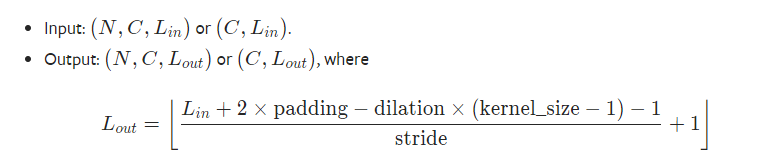
For maxpooling1d

For defaults, padding = 

In [ ]:
# class SequenceModeller(nn.Module):
#     def __init__(self, input_feature_dim, output_feature_dim,dtype = torch.float64):
#         super(SequenceModeller, self).__init__()
#         self.lstm = nn.LSTM(input_feature_dim, 1024, batch_first=True,dtype=dtype)
       
#         layers = []
#         #Layer 2
#         layers.append(nn.Linear(1024, 512,dtype=dtype))
#         layers.append(nn.ReLU())

#         # Layer3
#         layers.append(nn.Linear(512, output_feature_dim,dtype=dtype))
        

#         self.neuralnet = nn.Sequential(*layers)

#     def forward(self, x):
#         lstm_out, _ = self.lstm(x)
#         # print(lstm_out.shape)
#         output = self.neuralnet(lstm_out)
#         return output

In [ ]:
# class StatelessLSTM(nn.Module):
#     def __init__(self,input_feature_dim,conv_filters,kernel_size,conv_stride,stride_length,lstm_hidden_units,dtype = torch.float64):
#         super(StatelessLSTM, self).__init__()

#         self.conv1 = nn.Conv1d(in_channels=1,out_channels=conv_filters,stride=conv_stride,kernel_size=kernel_size,dtype=dtype)
#         self.conv2 = nn.Conv1d(in_channels=conv_filters,out_channels=1,kernel_size=kernel_size,stride=conv_stride,dtype=dtype)

#         conv1_output_size = (input_feature_dim - kernel_size) // conv_stride + 1
#         conv2_output_size = (conv1_output_size - kernel_size) // conv_stride + 1

#         self.lstm = nn.LSTM(conv2_output_size, lstm_hidden_units, batch_first=True,dtype=dtype)
#         self.dense = nn.Linear(lstm_hidden_units,stride_length,dtype=dtype)
        
#     def forward(self, x):

#         # print("Input Shape: ", x.shape)
#         x = x.unsqueeze(1)
#         # print("Input Shape after unsqueeze: ", x.shape)
#         x = torch.relu(self.conv1(x))
#         # print("Input Shape after conv1: ", x.shape)
#         x = torch.relu(self.conv2(x))
#         # print("Input Shape after conv2: ", x.shape)

#         # x = x.permute(0, 2, 1)
#         # print("Input Shape after permute: ", x.shape)
#         lstm_out, _ = self.lstm(x)
#         # print("Input Shape after lstm: ", lstm_out.shape)

#         output = self.dense(lstm_out)
#         output = output.reshape(output.size(0), -1) 
#         # print("Output Shape after dense: ", output.shape)
#         return output


### # Cell to check out the model structure

In [ ]:
# #Simple Model
# input_feature_dim = bufferSize
# output_feature_dim = frameSize
# model = SimpleModel(input_feature_dim, output_feature_dim)

# x = torch.randn(1, input_feature_dim)
# y = model(x)

# #===================================================================================================

# #Sequence Modeller
# model = SequenceModeller(input_feature_dim, output_feature_dim)

# x = torch.randn(1, input_feature_dim)
# y = model(x)
# # make_dot(y.mean(), params=dict(model.named_parameters()))

### # Model Training

-   Ideally it would be nice to a scheme => A batch of multiple frames, and the loss for the batch is the sum of the loss of the individual frames, which is then backpropped. This would be a good way to train the model. The batch also being shuffled and stuff

-   My current scheme => shuffle the full 3sec files and then, loss for a "full file" is calculated and backpropped

-   The current problem could be because I do STFT on single frames, and later take iSTFT on ALL the frames
    -   If that remains an issue then, I could do loss for each frame and then backprop 

-   Not a conventional training pattern I think, so maybe the training time is large

-   Question: In many papers, the STFT is done and then get the R and I components. Stack them up and use as input to the model

- Test the stft and istft
do framing stuff without the model, 50 percent overlap

In [ ]:
num_epochs = 250
fft_freq_bins = dataConfig.frameSize // 2 + 1
input_feature_dim = dataConfig.modelBufferFrames*fft_freq_bins
output_feature_dim = fft_freq_bins
# output_feature_dim = dataConfig.stride_length
# output_feature_dim = dataConfig.frameSize

# model = SimpleModel(input_feature_dim, output_feature_dim,dtype=dataConfig.dtype).to(device)
model = CRNNModel1D(input_feature_dim, output_feature_dim,dtype=dataConfig.dtype).to(device)

# model = SequenceModeller(input_feature_dim, output_feature_dim,dtype=dataConfig.dtype).to(device)

# model = StatelessLSTM(  input_feature_dim=input_feature_dim,
#                         conv_filters=32,
#                         kernel_size=5,
#                         conv_stride=3,
#                         stride_length=dataConfig.stride_length,
#                         lstm_hidden_units= 5,
#                         dtype=dataConfig.dtype
#                         ).to(device)

# Define your loss function (e.g., mean squared error)
loss_fn = nn.MSELoss()

# Define your optimizer (e.g., Adam optimizer)
optimizer = optim.Adam(model.parameters(), lr=dataConfig.learningRate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.8, verbose=False)


trainer = Trainer(
    model = model,
    optimizer = optimizer,
    scheduler = scheduler,
    loss_func = loss_fn,
    num_epochs = num_epochs,
)

trainer.train2(
    train_dataloader = dataloader,
    val_dataloader = validationDataloader,
    dataConfig = dataConfig,
    modelSaveDir = "/home/ubuntu/OticonStuff/models",
    wandbName = f'CRNNModel:{dataConfig.frameSize}_stride:{dataConfig.stride_length}_MBF:{dataConfig.modelBufferFrames}_LR:{dataConfig.learningRate}_BS:{dataConfig.batchSize}_Epochs:{num_epochs}_shuffle:{dataConfig.shuffle}',
    wavFileTesting = "19-198-0003.wav",
    debugFlag = False,
    useWandB=True,
    sweeping=False
)
